## Supplement
- Add duration

In [30]:
%run './lib/libraries.ipynb'

dython              0.6.1
tinydb              4.2.0


You should consider upgrading via the '/Users/duane.hinkley/PycharmProjects/c772-capstone-project/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/duane.hinkley/PycharmProjects/c772-capstone-project/venv/bin/python -m pip install --upgrade pip' command.


In [31]:
dfClean  = load_df('dfClean')
types = get_var_types()

###### Create dataframe with only completed items

In [32]:
dfSub = dfClean.filter(F.col('assessment_item_response_id').isNull()  == False)

###### Number of observations

In [5]:
dfSub.count()

64804

- 64, 804


###### Add attempt and item durations variables

In [33]:
dfSub = dfSub.withColumn(
    'item_attempt_duration_mins', (F.col('item_attempt_end_datetime_utc').cast('long') - F.col('item_attempt_start_datetime_utc').cast('long')) / 60
).withColumn(
    'student_duration_mins', (F.col('student_stop_datetime').cast('long') - F.col('student_start_datetime').cast('long')) / 60
)

pdDf = get_random_sample(dfSub).select('student_duration_mins','item_attempt_duration_mins').toPandas()

###### Duration Descriptive Statistics

In [34]:
pdDf.describe()

,student_duration_mins,item_attempt_duration_mins
count,6539.000000,6542.000000
mean,1285.723403,499.770040
std,6093.208897,3352.739651
min,0.000000,-54758.400000
25%,12.033333,0.466667
50%,28.883333,1.883333
75%,315.066667,9.716667
max,206222.850000,67532.350000


- Outliers
  - student_duration_mins
    - mean 28
    - 75% quartile 315
    - max 206,222
  - item_attempt_duration_mins
    - mean 2
    - 75% quartile 10
    - max 67,532

###### Outliers By Categorical / Nominal Values

In [20]:
# Categorical / Nominal Values
for f in types['nominalVars']:
    if (f != 'learner_attempt_status'):
        print(f)
        group_by_describe(dfSub, f, 'item_attempt_duration_mins').show()


assigned_item_status
+--------------------+-----+--------+-----+--------+
|assigned_item_status|count|     min| mean|     max|
+--------------------+-----+--------+-----+--------+
|              scored|64804|-54766.0|530.0|109353.0|
+--------------------+-----+--------+-----+--------+

ced_assignment_type_code
+------------------------+-----+--------+-----+--------+
|ced_assignment_type_code|count|     min| mean|     max|
+------------------------+-----+--------+-----+--------+
|                  rubric|   11|     0.0|  0.0|     0.0|
|                     clo|  214|     0.0|215.0| 21359.0|
|                practice| 1593|-35406.0|178.0| 27297.0|
|                    game| 1555|     0.0|  0.0|    24.0|
|              assessment|61431|-54766.0|553.0|109353.0|
+------------------------+-----+--------+-----+--------+

item_type_code_name
+-------------------+-----+--------+-----+--------+
|item_type_code_name|count|     min| mean|     max|
+-------------------+-----+--------+-----+--------

- Outliers in every group

###### Outliers By Categorical / Identifier

In [ ]:
# Categorical / Nominal Values
for f in types['identifierVars']:
    if (f != 'learner_attempt_status'):
        print(f)
        group_by_describe(dfSub, f, 'item_attempt_duration_mins').show(100)

- No pattern

###### Outliers By Categorical / Identifier

In [23]:
for f in ['org_id', 'section_id', 'learner_id', 'assessment_id']:
    if (f != 'learner_attempt_status'):
        print(f)
        group_by_describe(dfSub, f, 'item_attempt_duration_mins').show(100)

org_id
+------+-----+--------+-----+--------+
|org_id|count|     min| mean|     max|
+------+-----+--------+-----+--------+
|117713|10310|-35406.0| 43.0| 27297.0|
|130845|30301|-54766.0|339.0| 54806.0|
| 19164|24193|     0.0|976.0|109353.0|
+------+-----+--------+-----+--------+

section_id
+----------+-----+--------+------+--------+
|section_id|count|     min|  mean|     max|
+----------+-----+--------+------+--------+
|    151413|  150|     0.0|5526.0| 34073.0|
|    150278| 4675|     0.0|  58.0|  9974.0|
|    270010| 1805|     0.0| 998.0| 12966.0|
|    150165| 5406|-35406.0|  49.0| 27297.0|
|    150062|  416|     0.0|   5.0|   137.0|
|    190290| 6005|     0.0| 191.0| 10707.0|
|    171183|  168|     0.0|3093.0| 22635.0|
|    224222|  448|     0.0| 327.0|  2847.0|
|    157833|  180|     0.0|1572.0| 29809.0|
|    297288|  359|     0.0| 200.0|  4406.0|
|    215692|    3|     0.0|   0.0|     0.0|
|    190142| 2092|     0.0| 110.0| 30120.0|
|    298667|    4|     0.0| 355.0|  1412.0|
|   

- No pattern

###### By Month

In [28]:
def by_date(pdDf,statsCol):
    # Min and Max date plus and minus one month
    max = pd.to_datetime(pdDf.max().max(), unit='s') + pd.DateOffset(months=1)
    min = pd.to_datetime(pdDf.min().min(), unit='s') - pd.DateOffset(months=1)


    # Date labels by month
    yLabels = pd.date_range(start=min.date(), end=max.date(), freq='MS')
    print (yLabels)
    # Convert ticks to unix timestamp (int)
    ytick = [t.value // 10 ** 9 for t in yLabels]
    start = 0
    for end in ytick:
        print (start, end)
        dfSub.filter(
            ~F.col('item_attempt_start_datetime_utc').cast('long').between(start, end)
        ).agg(
          F.round( F.count(statsCol) ).alias('count'),
          F.round( F.min(statsCol) ).alias('min'),
          F.round( F.avg(statsCol) ).alias('mean'),
          F.round( F.max(statsCol) ).alias('max')
        ).show()
        start = end + 1

by_date(pdDf, 'item_attempt_duration_mins');

DatetimeIndex(['1969-12-01', '1970-01-01', '1970-02-01'], dtype='datetime64[ns]', freq='MS')
0 -2678400
+-----+--------+-----+--------+
|count|     min| mean|     max|
+-----+--------+-----+--------+
|64804|-54766.0|530.0|109353.0|
+-----+--------+-----+--------+

-2678399 0
+-----+--------+-----+--------+
|count|     min| mean|     max|
+-----+--------+-----+--------+
|64804|-54766.0|530.0|109353.0|
+-----+--------+-----+--------+

1 2678400
+-----+--------+-----+--------+
|count|     min| mean|     max|
+-----+--------+-----+--------+
|64804|-54766.0|530.0|109353.0|
+-----+--------+-----+--------+



In [35]:
for f in ['student_start_datetime', 'student_stop_datetime', 'item_attempt_start_datetime_utc', 'item_attempt_end_datetime_utc']:
  print (f)
  dfFlt.agg(
    F.countDistinct(f).alias('unique'),
    F.count(F.when(F.col(f).isNull(), f)).alias('null'),
    F.min(f).alias('min'),
    F.max(f).alias('max')
 ).show(1, False)

student_start_datetime
+------+----+-----------------------+-----------------------+
|unique|null|min                    |max                    |
+------+----+-----------------------+-----------------------+
|7385  |749 |2019-08-22 01:57:32.893|2020-05-26 04:59:17.367|
+------+----+-----------------------+-----------------------+

student_stop_datetime
+------+----+-----------------------+-----------------------+
|unique|null|min                    |max                    |
+------+----+-----------------------+-----------------------+
|7127  |749 |2019-08-22 02:37:59.012|2020-05-26 04:59:17.367|
+------+----+-----------------------+-----------------------+

item_attempt_start_datetime_utc
+------+-----+-------------------+-------------------+
|unique|null |min                |max                |
+------+-----+-------------------+-------------------+
|60182 |14999|2019-08-23 14:11:53|2020-05-26 03:56:13|
+------+-----+-------------------+-------------------+

item_attempt_end_datetime

In [ ]:
pdDf.hist('item_attempt_duration_mins', bins=100)

array([[<AxesSubplot:title={'center':'student_duration_mins'}>]],
      dtype=object)

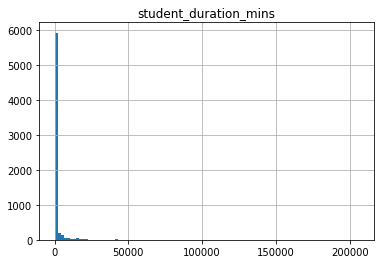

In [10]:
pdDf.hist('student_duration_mins', bins=100)

<AxesSubplot:>

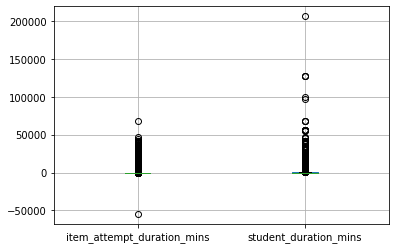

In [22]:
pdDf.boxplot(['item_attempt_duration_mins', 'student_duration_mins'])

In [17]:
pdDf.describe()

,student_duration_mins,item_attempt_duration_mins
count,77220.000000,65515.000000
mean,1560.926878,523.978035
std,7559.147777,3454.616137
min,-1362.766667,-54766.016667
25%,6.166667,0.416667
50%,24.166667,1.800000
75%,253.466667,9.533333
max,261008.166667,109353.100000


In [19]:
dfSub.select('student_duration_mins','item_attempt_duration_mins').describe().show()

+-------+---------------------+--------------------------+
|summary|student_duration_mins|item_attempt_duration_mins|
+-------+---------------------+--------------------------+
|  count|                77220|                     65515|
|   mean|   1560.9268775360476|         523.9780348011907|
| stddev|    7559.147776612103|        3454.6161374710928|
|    min|  -1362.7666666666667|        -54766.01666666667|
|    max|   261008.16666666666|                  109353.1|
+-------+---------------------+--------------------------+



#### Investigate Long Durations

In [20]:
dfLong = dfSub.filter( ~F.col('student_duration_mins').between(-300, 300) )

###### Count Long Durations

In [21]:
dfLong.count()

16341

- 18,880

###### Display boxplot of dates

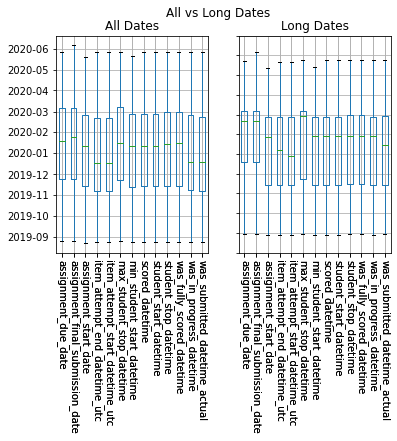

In [25]:
dual_date_boxplot(
    get_random_sample(dfClean),
    dfLong,
    title1="All Dates",
    title2='Long Dates',
    main='All vs Long Dates'
)

In [41]:
dfShort = dfSub.filter( F.col('item_attempt_duration_mins').between(-7, 7) )

###### Count Short Durations

In [42]:
dfShort.count()

45712

- 58,340

###### Describe

In [43]:
dfShort.select('student_duration_mins','item_attempt_duration_mins').describe().show()

+-------+---------------------+--------------------------+
|summary|student_duration_mins|item_attempt_duration_mins|
+-------+---------------------+--------------------------+
|  count|                45682|                     45712|
|   mean|    841.8166925703586|        1.5199550081671018|
| stddev|    5132.173204151978|        1.6827352864897638|
|    min|                  0.0|                       0.0|
|    max|   261008.16666666666|                       7.0|
+-------+---------------------+--------------------------+



- 58,340


###### Display boxplot of dates

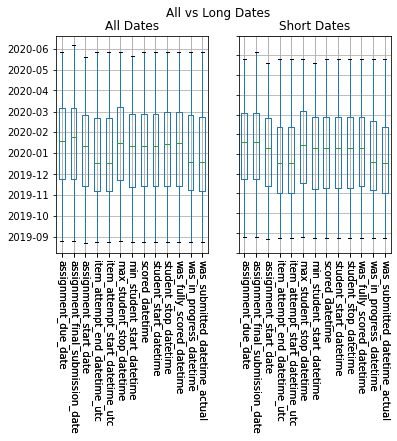

In [29]:
dual_date_boxplot(
    get_random_sample(dfClean),
    dfShort,
    title1="All Dates",
    title2='Short Dates',
    main='All vs Long Dates'
)

In [ ]:
dfShort.toPandas().boxplot('item_attempt_duration_mins')

array([[<AxesSubplot:title={'center':'item_attempt_duration_mins'}>]],
      dtype=object)

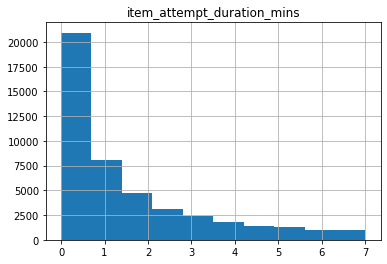

In [45]:
dfShort.toPandas().hist('item_attempt_duration_mins')

In [ ]:
dfShort.toPandas().boxplot('student_duration_mins')